In [92]:
import tensorflow as tf
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [93]:

DIR_KNOWNS = 'knowns'  #Imagenes de una persona, la carpeta se puede decir que es un empleado
DIR_UNKNOWNS = 'unknowns' #Imagenes de entrada esta solo podria se una imagen XD
DIR_RESULTS = 'results'

In [94]:
# Leer mobilenet_graph.pb
with tf.io.gfile.GFile('graph_face.pb','rb') as f:
  graph_def = tf.compat.v1.GraphDef()
  graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
  tf.import_graph_def(graph_def, name='')
  

In [95]:
#def load_image(DIR,NAME):
 #  return cv2.cvColor(cv2.imread(f'{DIR}/{NAME}'),cv2.COLOR_BGR2RGB)
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{NAME}'), cv2.COLOR_BGR2RGB)


    ymin, xmin, ymax, xmax = boxes[index,:]
    (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
    left, right, top, bottom = int(left), int(right), int(top), int(bottom)
    bboxes.append((left, top, right, bottom))

In [96]:
def detect_faces(image, score_threshold=0.7):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)
    
    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')
    
    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})
    
    # Reajustar tamaños boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)
    
    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]
    
    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])
        
    return bboxes


In [97]:


# Dibujar bounding boxes
def draw_box(image,box,color,line_width=6):
    if box==[]:
        return image
    else:
        cv2.rectangle(image,(box[0],box[2]),(box[1],box[3]),color,line_width)
    return image

[[797, 2524, 1576, 3315]]


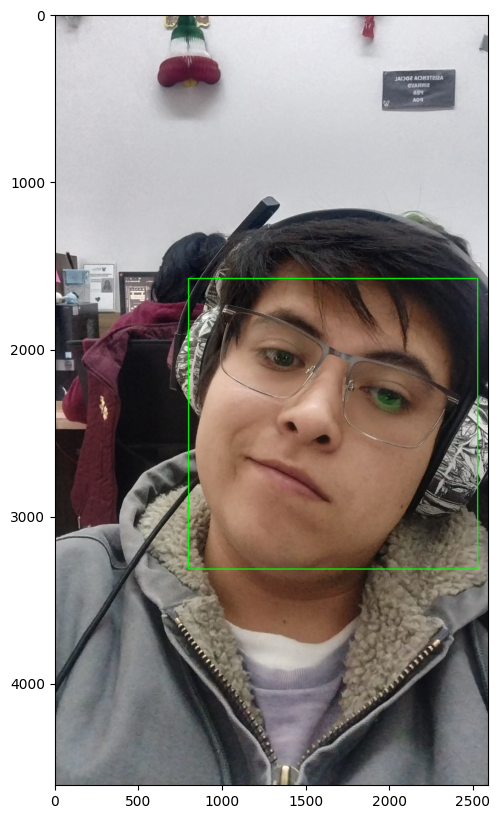

In [98]:
name = 'img10.jpg'
image = load_image(DIR_UNKNOWNS,name)
bboxess = detect_faces(image)
print(bboxess)
#detected_faces = draw_box(image,bboxes[0],(0,255,0))
for box in bboxess:
   detected_faces = draw_box(image,box,(0,255,0))
fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)

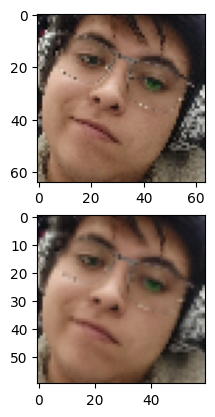

In [99]:
def extract_faces(image,bboxes,new_size=(64,64)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces
faces = extract_faces(image,bboxess)
plt.subplot(2,1,1)
plt.imshow(faces[0])
plt.subplot(2,1,2)
plt.imshow(cv2.resize(faces[0],dsize=(60,60)))

In [100]:
from tensorflow.keras import layers
from skimage.transform import resize
from skimage.io import imread_collection

sebas = 'sevasR/*.jpg'
otros = 'otrosR/*.jpg'

sevas = imread_collection(sebas)
otlos = imread_collection(otros)

TT = np.append(sevas, otlos, axis=0)

X = np.array(TT)
X = resize(X,(len(TT),64,64,3))


modelo = tf.keras.Sequential()
modelo.add(layers.Conv2D(200,(3,3),input_shape=X.shape[1:]))
modelo.add(layers.Activation('relu'))
modelo.add(layers.MaxPooling2D(pool_size=(2,2)))
#La primera capa de CNN seguida por las capas de Relu y MaxPooling

modelo.add(layers.Conv2D(100,(3,3)))
modelo.add(layers.Activation('relu'))
modelo.add(layers.MaxPooling2D(pool_size=(2,2)))
#La segunda capa de convolución seguida por las capas de Relu y MaxPooling

modelo.add(layers.Conv2D(50,(3,3)))
modelo.add(layers.Activation('relu'))
modelo.add(layers.MaxPooling2D(pool_size=(2,2)))
#La tercera capa de convolución seguida por las capas de Relu y MaxPooling

modelo.add(layers.Flatten()) #Imagen profunda la vamos a hacer plana, es decir solo una dimension,
#va tener toda nuestra informacion de la cnn

modelo.add(layers.Dropout(0.5)) # Apagamos 50% de las neuronas cada paso, asi evitamos sobreajustar
#(evitar un solo camino de entrenamiento)

modelo.add(tf.keras.layers.Dense(50,activation='relu'))
#Capa Densa de 50 neuronas

modelo.add(layers.Dense(2,activation='softmax')) #La capa final softmax con dos salidas para dos categorías
#Softmax nos indica que tanta probabilidad tiene cada clase, y por ende saber cual tiene la maxima probabilidad

modelo.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo.save('modeloModelo.h5')
print(X.shape[1:])

(64, 64, 3)


In [101]:
nModelo = load_model('modeloModelo.h5')
print(nModelo.input_shape)
print(nModelo.output_shape)
#face_clsfr = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')



(None, 64, 64, 3)
(None, 2)


In [103]:
def compute_embedding(model,face):
    face = face.astype('float32')
    
    mean, std = face.mean(), face.std()
    face = (face - mean) / std
    
    face = np.expand_dims(face,axis=0)
    
    embedding = model.predict(face)
    return embedding


embed = compute_embedding(nModelo,faces[0])
print(embed)


1/1 [==============================] - 0s 48ms/step
[[0.48670015 0.5132999 ]]


In [105]:
# Embeddings referencia
known_embeddings = []

print('Procesando rostros conocidos...')
for name in os.listdir('sevasR'):
    if name.endswith('.jpg'):
        print(f'   {name}')
        image = load_image(DIR_KNOWNS,name)
        bboxes = detect_faces(image)
        face = extract_faces(image,bboxes)
        known_embeddings.append(compute_embedding(facenet,face[0])) 

Procesando rostros conocidos...
   img1.jpg


ValueError: in user code:

    File "c:\Users\traba\Downloads\FaceID\.conda\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\traba\Downloads\FaceID\.conda\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\traba\Downloads\FaceID\.conda\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\traba\Downloads\FaceID\.conda\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\traba\Downloads\FaceID\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\traba\Downloads\FaceID\.conda\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 90, 3, 1), found shape=(None, 64, 64, 3)
